# Royal Devon University Healthcare NHS Foundation Trust Significant Expenditure Data

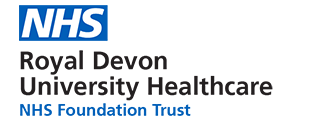

#### The data includes invoices, grant payments, expenses and other such payments, for costs over £25,000. It excludes payroll expenditure.

## Contents
* Data Extraction
* Data Cleaning
* Monthly Expenditure
* Biggest Expenditure Type?
* Are Staff Costs Increasing?
* Distribution of Expenses
* Which suppliers do we spend the most with?
* EPIC Spending

## Import Dependencies

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import bs4
import requests
import webbrowser
import io
import calendar
import re
sns.set_style('whitegrid')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Scrape URLs from website
<a id='datae'></a>

In [114]:
r = requests.get('https://www.royaldevon.nhs.uk/about-us/information-governance/freedom-of-information-foi-and-environmental-information-regulations-eir/expenditure-data/#')
soup = bs4.BeautifulSoup(r.text, 'html.parser')
urls = soup.find_all('section', class_='static-content')

### Extract URLS from data

In [115]:
hrefs = []
for list in urls:
    x = list.find_all('a')
    for item in x:
        hrefs.append(item['href'])

filtered_hrefs = [element for element in hrefs if 'media' in element]
filtered_hrefs 

['/media/ikocrzc3/transactions-over-25-000-january-2023.xlsx',
 '/media/ukfni2cl/transactions-over-25-000-february-2023.xlsx',
 '/media/twujoxok/transactions-over-25-000-march-2023.xlsx',
 '/media/gyxk5pde/transactions-over-25-000-april-2022.xlsx',
 '/media/54yi2h1q/transactions-over-25-000-may-2022.xlsx',
 '/media/pybng4x1/transactions-over-25-000-june-2022.xlsx',
 '/media/hielwogy/transactions-over-25-000-july-2022.xlsx',
 '/media/a33mzwdf/transactions-over-25-000-august-2022.xlsx',
 '/media/a4nnp3ed/transactions-over-25-000-september-2022.xlsx',
 '/media/ka3fhi0u/transactions-over-25-000-october-2022.xlsx',
 '/media/ubear5s2/transactions-over-25-000-november-2022.xlsx',
 '/media/5lsfixmr/transactions-over-25-000-december-2022.xlsx']

### Download each excel document and read into Pandas DataFrame

In [116]:
merged_df = pd.DataFrame()

for html in filtered_hrefs:
    url = f'https://www.royaldevon.nhs.uk{html}'
    response = requests.get(url)
    if response.status_code == 200:
        excel_data = io.BytesIO(response.content)
        temp = pd.read_excel(excel_data)
        merged_df = pd.concat([merged_df, temp])
    else:
        print(f"Failed to download file from {url}")    
print('Completed')

Completed


In [117]:
merged_df.head()

,Department Family,Entity,Posted Date,Expenses Type(T),Expenses Area(T),Supplier(T),Transaction No,Amount less recoverable VAT,VAT RegNo,Area
0,NHS,Royal Devon University Healthcare NHSFT,2022-12-30,Benchmarking Membership,Theatres,IQVIATECHNOL,1273092,27000.00,NaN,NaN
1,NHS,Royal Devon University Healthcare NHSFT,2022-12-23,Building Contract,Corporate,FIFIELDSLIMI,1272351,105110.58,NaN,NaN
2,NHS,Royal Devon University Healthcare NHSFT,2022-12-22,Building Contract,Corporate,PEARCECONSTR,1272358,27901.64,NaN,NaN
3,NHS,Royal Devon University Healthcare NHSFT,2022-12-23,Building Contract,Corporate,WESTCOUNTRYM,1272740,161128.86,NaN,NaN
4,NHS,Royal Devon University Healthcare NHSFT,2022-12-23,Building Contract,Corporate,WESTCOUNTRYM,1272739,26280.41,NaN,NaN


In [118]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2639 entries, 0 to 170
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Department Family            2639 non-null   object        
 1   Entity                       2639 non-null   object        
 2   Posted Date                  2540 non-null   datetime64[ns]
 3   Expenses Type(T)             2639 non-null   object        
 4   Expenses Area(T)             2500 non-null   object        
 5   Supplier(T)                  2639 non-null   object        
 6   Transaction No               2639 non-null   int64         
 7   Amount less recoverable VAT  2639 non-null   float64       
 8   VAT RegNo                    1677 non-null   object        
 9   Area                         434 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 226.8+ KB


In [119]:
merged_df.describe()

,Transaction No,Amount less recoverable VAT
count,2639.00,2639.00
mean,334189786.70,88004.16
std,236810255.14,153683.26
min,44964.00,-1700352.00
25%,1272354.50,33058.62
50%,502471579.00,47692.80
75%,502534998.50,90958.90
max,502588092.00,2487789.72


In [120]:
merged_df.nunique()

Department Family                 1
Entity                            2
Posted Date                     283
Expenses Type(T)                138
Expenses Area(T)                289
Supplier(T)                     415
Transaction No                 2615
Amount less recoverable VAT    1903
VAT RegNo                       230
Area                              2
dtype: int64

### Data Cleaning and initial Feature Engineering
<a id='datac'></a>

In [121]:
# Renaming columns
merged_df.rename(columns={'Amount less recoverable VAT': 'Amount'}, inplace=True)

In [122]:
# Create Year Column
merged_df['Year'] = merged_df['Posted Date'].dt.year
# Create Monthly Column
merged_df['Month'] = merged_df['Posted Date'].dt.month

# Removing 2020/2021 Data from Dataset for analysis (some was found in analysis)
# This would depend whether these took place in said year as to whether they were relevant
# May be why they were included, however for analysis, we will exclude

merged_df['Year'].value_counts()
merged_df = merged_df[merged_df['Year'].isin([2022, 2023])]

In [123]:
# Note: Distribution of data has negative expenses.
negativedf = merged_df[merged_df['Amount']<0]
merged_df = merged_df[merged_df['Amount']>0]

## Questions about the Data
* Month that expenditure is highest in
* Top 5 expenditure outlets
* Distribution of the data
* Are there any frequent suppliers that we use and are those costs going up?
* EPIC spending after system changes

### Expenditure by month

In [124]:
# Group by monthly data
byMonths = merged_df.groupby('Month').sum()
byMonths.reset_index(inplace=True)
# Change Month Number to Name
byMonths['Month'] = byMonths['Month'].apply(lambda x: calendar.month_name[int(x)])
byMonths.head()


,Month,Transaction No,Amount,Year
0,January,79952719191,21104628.14,410665.00
1,February,69392528933,14535609.17,343909.00
2,March,128693219090,26287705.57,570460.00
3,April,70447214857,21755609.36,485280.00
4,May,64449090935,22397849.24,495390.00


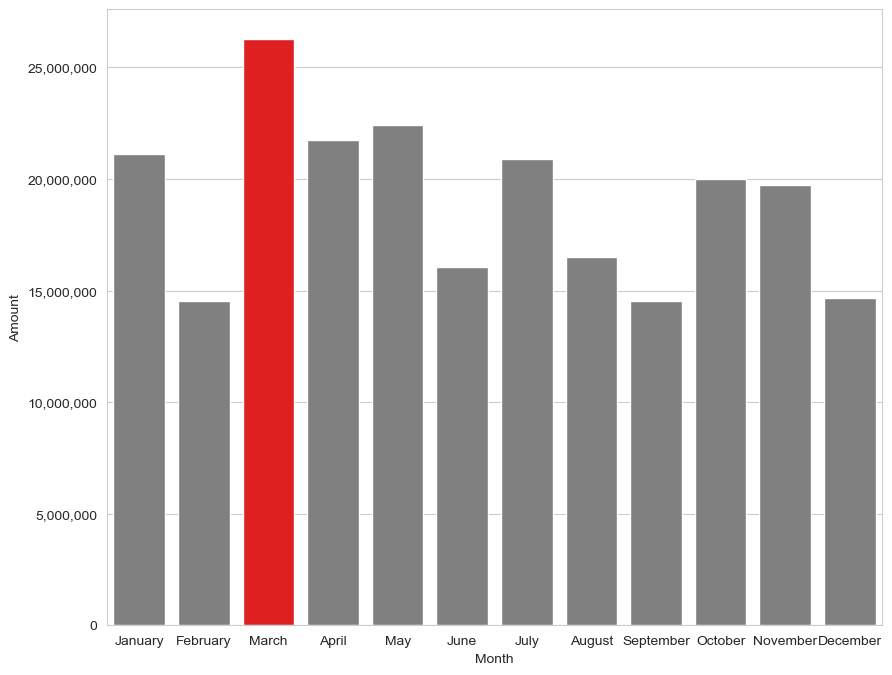

In [168]:
# Vizualize Data
x = byMonths['Amount']
plt.figure(figsize=(10, 8))
clrs = ['grey' if (month < max(byMonths['Amount'])) else 'red' for month in byMonths['Amount'] ]
sns.barplot(x='Month', y='Amount', data=byMonths, palette=clrs)
plt.ticklabel_format(style='plain', axis='y')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

## Biggest Expenditure Type
<a id='etype'></a>

In [126]:
merged_df['Expenses Type(T)'].value_counts().head(30)

Drug purchases                         338
Other services received                177
Services Received - Non-NHS            167
Staff                                  126
Clinical Supplies                      104
Pharmacy                               103
Equipment                               95
Hospital Bulk Purchases                 79
Software costs                          78
SLA                                     78
Electricity                             74
Equipment - Fixed Assets                70
Buildings - Fixed Assets                54
Chemicals                               53
Leases Buildings Liability > 1 year     50
Finance Service                         45
Software                                41
Construction Costs                      33
Gas                                     31
Corporate                               30
Maintenance Contract                    28
Lab. equipment                          26
General rates                           25
Med. equipm

In [127]:
# Grouping by type of expense and sorting by descending
byType = merged_df.groupby('Expenses Type(T)').sum()
byType.reset_index(inplace=True)
byType.drop(columns=['Month'], inplace=True)

# Create DataFrame for Top 5 biggest expenses
top_ten = byType.sort_values('Amount', ascending=False).head(10)
top_ten

,Expenses Type(T),Transaction No,Amount,Year
26,Drug purchases,169848224648,16210602.08,683537.00
78,Outsource Management Fees,12060016155,14712503.22,48533.00
47,Hospital Bulk Purchases,39699118302,14556046.69,159766.00
111,Staff,47181671,14011755.34,254784.00
104,Services Received - Non-NHS,83918553798,13528945.09,337715.00
77,Other services received,88942617988,13461787.30,357934.00
33,Equipment,6636159716,11266550.90,192099.00
99,SLA,61805163,10295895.78,157720.00
40,Finance Service,47151191,9110913.09,90998.00
12,Chemicals,26632673655,7924209.69,107180.00


,Expenses Type(T),Transaction No,Amount,Year
26,Drug purchases,169848224648,16210602.08,683537.00
78,Outsource Management Fees,12060016155,14712503.22,48533.00
47,Hospital Bulk Purchases,39699118302,14556046.69,159766.00
111,Staff,47181671,14011755.34,254784.00
104,Services Received - Non-NHS,83918553798,13528945.09,337715.00
77,Other services received,88942617988,13461787.30,357934.00
33,Equipment,6636159716,11266550.90,192099.00
99,SLA,61805163,10295895.78,157720.00
40,Finance Service,47151191,9110913.09,90998.00
12,Chemicals,26632673655,7924209.69,107180.00


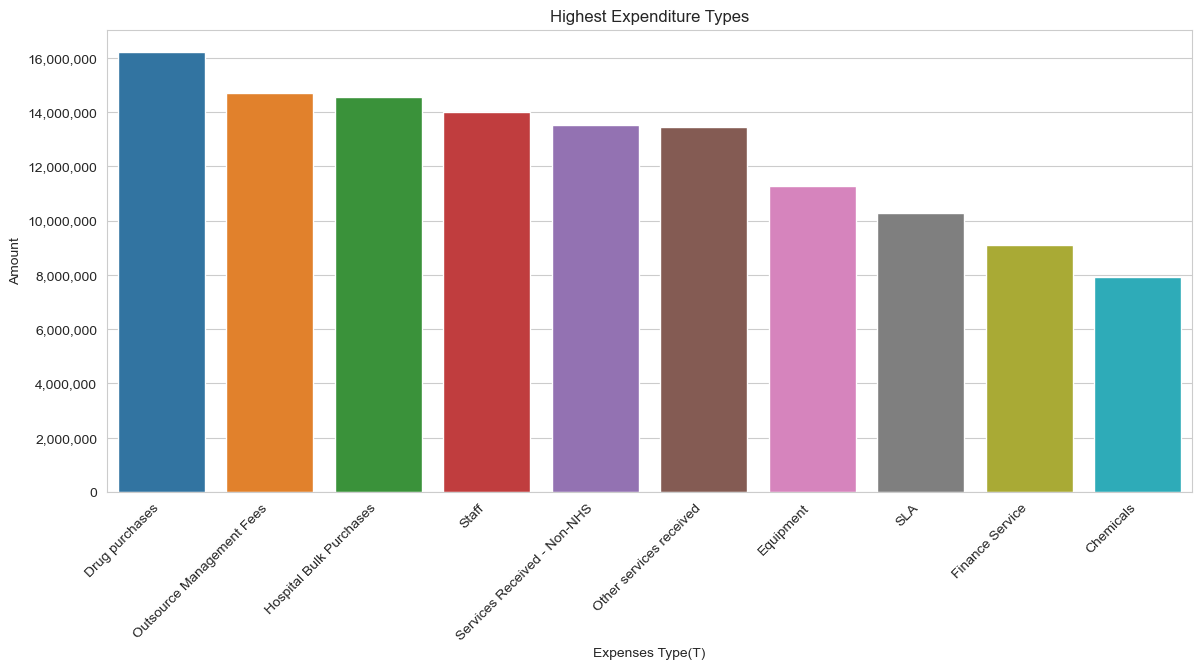

In [128]:
# Plot
x = top_ten['Expenses Type(T)']
y = top_ten['Amount']
plt.figure(figsize=(14, 6))
sns.barplot(x=x, y=y)
plt.ticklabel_format(style='plain', axis='y')
plt.title('Highest Expenditure Types')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
top_ten

## Are staff costs increasing?
<a id='scost'></a>

In [129]:
# Create DataFrame for Expense Type containing 'Staff'
expStaff = merged_df[merged_df['Expenses Type(T)'].str.contains('Staff')]
byStaff = expStaff.groupby(['Year', 'Month']).sum()
byStaff.drop(columns=['Transaction No'], inplace=True)
# Merge Year and Month
byStaff = byStaff.reset_index()
byStaff['Date'] = pd.to_datetime(byStaff[['Year', 'Month']].assign(day=1))
byStaff

,Year,Month,Amount,Date
0,2022.00,4.00,1625741.07,2022-04-01
1,2022.00,5.00,362274.09,2022-05-01
2,2022.00,6.00,1627671.18,2022-06-01
3,2022.00,7.00,1127097.00,2022-07-01
4,2022.00,8.00,1452847.26,2022-08-01
5,2022.00,9.00,1577885.90,2022-09-01
6,2022.00,10.00,1692541.22,2022-10-01
7,2022.00,11.00,1574238.77,2022-11-01
8,2022.00,12.00,1471412.34,2022-12-01
9,2023.00,1.00,848400.53,2023-01-01


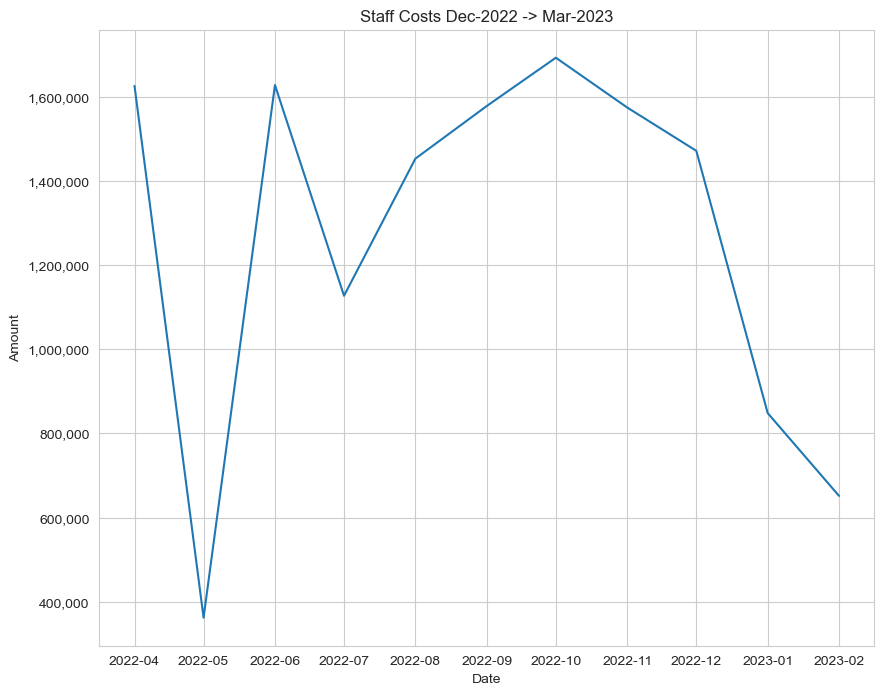

In [156]:
# Visualize Data
plt.figure(figsize=(10, 8))
sns.lineplot(data=byStaff, x='Date', y='Amount')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Staff Costs Dec-2022 -> Mar-2023')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.show()

* Not clear, disparities may be due to fluctiations in periods relating to payday differences 
* Also doesn't contain absolute expenditure on Staff Costs, doens't include payroll data

## Distribution of Expenses
<a id='de'></a>

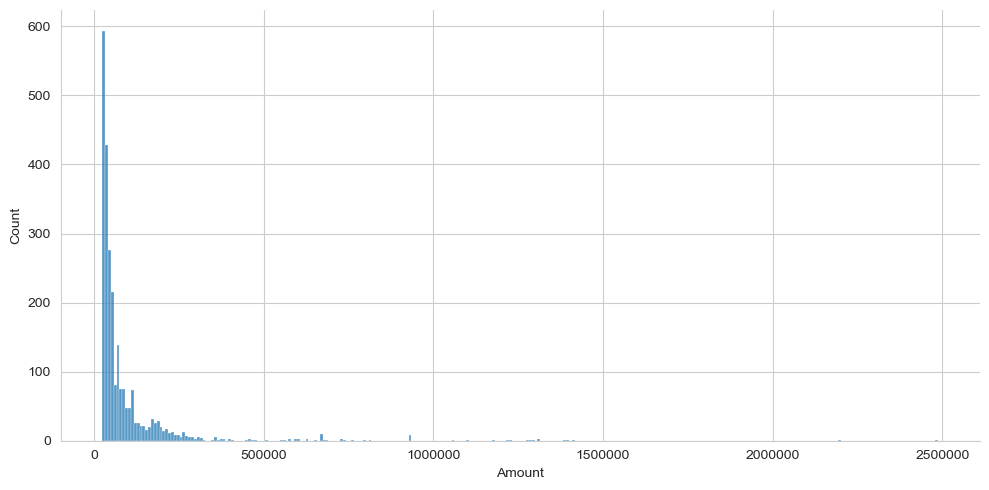

<Figure size 100x800 with 0 Axes>

In [131]:
sns.displot(merged_df['Amount'], height=5, aspect = 2)
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
plt.figure(figsize=(1, 8));

In [132]:
merged_df['Amount'].describe()

count      2480.00
mean      92126.20
std      149780.82
min       25020.00
25%       34015.20
50%       48118.67
75%       91245.60
max     2487789.72
Name: Amount, dtype: float64

<Figure size 100x800 with 0 Axes>

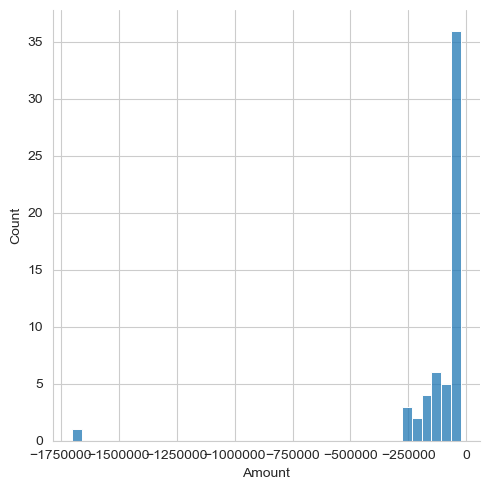

<Figure size 100x800 with 0 Axes>

In [174]:
sns.displot(negativedf['Amount'])
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
plt.figure(figsize=(1, 8))

* Negative Expenses - grant payments(?)

In [134]:
negativedf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 183 to 166
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Department Family  57 non-null     object        
 1   Entity             57 non-null     object        
 2   Posted Date        57 non-null     datetime64[ns]
 3   Expenses Type(T)   57 non-null     object        
 4   Expenses Area(T)   57 non-null     object        
 5   Supplier(T)        57 non-null     object        
 6   Transaction No     57 non-null     int64         
 7   Amount             57 non-null     float64       
 8   VAT RegNo          52 non-null     object        
 9   Area               9 non-null      object        
 10  Year               57 non-null     float64       
 11  Month              57 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(7)
memory usage: 5.8+ KB


In [175]:
negativedf.describe()

,Transaction No,Amount,Year,Month
count,57.00,57.00,57.00,57.00
mean,502530935.25,-108666.43,2022.58,4.51
std,51702.63,225029.13,0.50,2.90
min,502434499.00,-1700352.00,2022.00,1.00
25%,502491170.00,-116039.05,2022.00,2.00
50%,502559438.00,-43844.19,2023.00,3.00
75%,502576400.00,-34226.85,2023.00,6.00
max,502587470.00,-25054.50,2023.00,11.00


In [186]:
biggest_grant = negativedf['Amount'].idxmin()
negativedf[negativedf['Amount'].index == biggest_grant]

,Department Family,Entity,Posted Date,Expenses Type(T),Expenses Area(T),Supplier(T),Transaction No,Amount,VAT RegNo,Area,Year,Month
196,NHS,Royal Devon University Healthcare NHS Foundati...,2022-05-24,General rates,Utilities - RDE Wonford Site,EXETER CITY COUNCIL,502451590,-1700352.00,NaN,Eastern,2022.00,5.00


## Which suppliers do we spend the most with?
<a id='suppliers'></a>

In [152]:
supplierdf = merged_df.groupby('Supplier(T)').sum().sort_values('Amount', ascending=False)
supplierdf.head(10)

,Transaction No,Amount,Year,Month
Supplier(T),,,,
BOOTS UK LTD,12060016155,14712503.22,48533.00,160.00
NHS SUPPLY CHAIN - CONSUMABLES (A/C 2247/S534),39699118302,14556046.69,159766.00,507.00
NHSPROFESSIO,8577062,14102591.94,216364.00,751.00
SODEXOLTD(HE,60400409,9222438.93,97057.00,315.00
NHSRESOLUTIO,413753,8399415.60,18199.00,63.00
EDF ENERGY LTD,37187089305,6189222.72,149668.00,360.00
ROCHE DIAGNOSTICS LIMITED,5025437473,5868593.34,20228.00,28.00
NHS PROPERTY SERVICES LTD,46731294155,5818014.43,188065.00,523.00
NHSSUPPLYCHA,7210528,5277222.20,155706.00,532.00


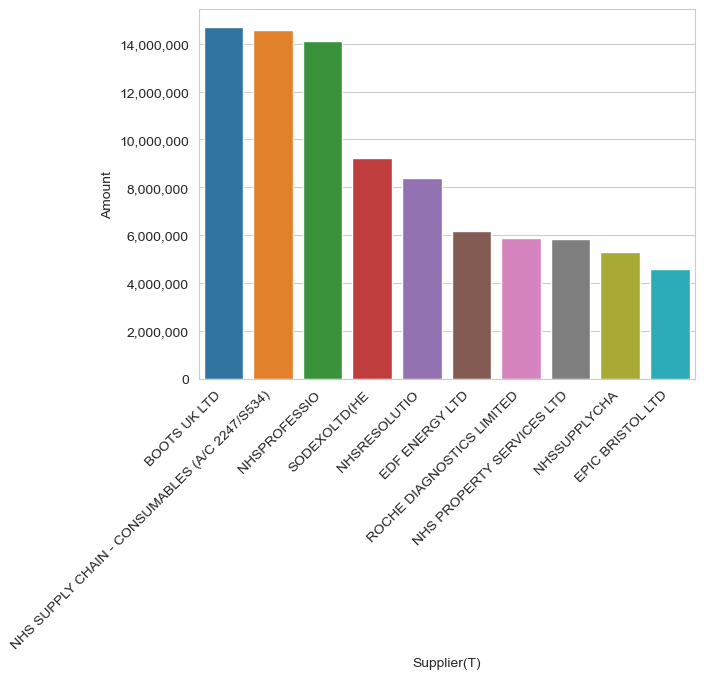

In [154]:
y = supplierdf['Amount'].head(10)
x= supplierdf.head(10).index

ax = sns.barplot(x=x, y=y)

plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45, ha='right')  
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

## EPIC spending over the last year
<a id='epic'></a>

In [104]:
merged_df['Supplier(T)'].value_counts().head(10)

NHSPROFESSIO                                      107
NHS PROPERTY SERVICES LTD                          93
NHS SUPPLY CHAIN - CONSUMABLES (A/C 2247/S534)     79
NHSSUPPLYCHA                                       77
EDF ENERGY LTD                                     74
BAYERPLC                                           52
ALLIANCE HEALTHCARE (DISTRIBUTION) LTD             51
ALLOGA UK LTD                                      49
SODEXOLTD(HE                                       48
BATH ASU                                           47
Name: Supplier(T), dtype: int64

In [107]:
epicdf = merged_df[merged_df['Supplier(T)'].str.contains('epic', re.I == False)].copy()
epicdf['Date'] = pd.to_datetime(epicdf[['Year', 'Month']].assign(day=1))
epicdf = epicdf.groupby('Date').mean()
epicdf.reset_index(inplace=True)
epicdf.head()

,Date,Transaction No,Amount,Year,Month
0,2022-04-01,502437091.00,159605.50,2022.00,4.00
1,2022-06-01,335392987.67,225928.55,2022.00,6.00
2,2022-07-01,502473788.89,97037.22,2022.00,7.00
3,2022-08-01,502482006.00,28674.00,2022.00,8.00
4,2022-09-01,502496868.17,134397.17,2022.00,9.00


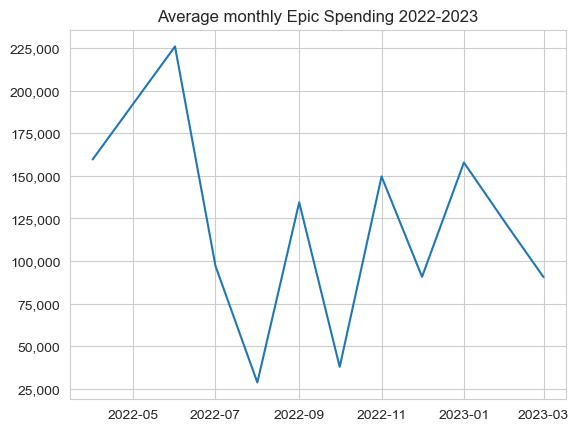

In [155]:
y = epicdf['Amount']
x = epicdf['Date']
plt.plot(x, y)
plt.title('Average monthly Epic Spending 2022-2023')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))